In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels as sms
import statsmodels.api as sm

pd.set_option('display.max_rows',60000)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',200)
pd.options.display.float_format = '{:,.10f}'.format
import warnings
warnings.filterwarnings("ignore")

# Black Litterman Implementation 

In [2]:
d1 = pd.read_csv('outputs/my_data_view_1_0307.csv')\
[['name','last_actual_date','real_price','cum_return_40d','return_price_40d']].copy()
d1['perc_'] = d1['cum_return_40d'] - 1.0


d2 = pd.read_csv('mini_portfolios_0219.csv')[['Ticker','Sector','Beta','Sector_Weight']].copy()

d3 = pd.merge(d1,d2,how='outer',left_on='name',right_on='Ticker')

d3_output = d3[['Ticker','perc_','Sector','Sector_Weight','Beta']].copy()
#d3_output.to_csv('for_blacklitter.csv')

In [3]:
ext = pd.read_csv('dataset_250222_run.csv', parse_dates=['date'])[['date','ticker_id','sector','close']].copy()

# Set cutoff date
cutoff_date = pd.to_datetime('2024-10-04')

# Filter data to only include dates up to the cutoff
ext = ext[ext['date'] <= cutoff_date]

# Create an empty list to hold each stock's column
price_columns = []

# Loop through each unique ticker
for ticker in ext['ticker_id'].unique():
    stock_df = ext[ext['ticker_id'] == ticker].sort_values('date', ascending=False).head(200)
    
    # Sort prices in ascending order (oldest to newest)
    stock_prices = stock_df.sort_values('date')['close'].reset_index(drop=True)
    
    # Rename the column to the ticker
    stock_prices.name = ticker
    
    # Append to list
    price_columns.append(stock_prices)

# Concatenate all columns side by side
final_df = pd.concat(price_columns, axis=1)

In [13]:
import pandas as pd
import numpy as np
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting

def optimize_sector_portfolio2( risk_level):
    """
    Run a Black-Litterman optimization at the sector level.

    Parameters:
    - file_path: Path to the CSV file with columns: Ticker, perc_, Sector, Sector_Weight
    - risk_level: 'very low', 'low', 'mid', 'high', or 'very high'

    Returns:
    - Dictionary of optimized sector weights
    """
    # ---- Load CSV ----
    df = pd.read_csv("for_blacklitter.csv")

    # ---- Sector-Level Weighted Views ----
    df["weighted_view"] = df["perc_"] * df["Sector_Weight"]
    sector_views = df.groupby("Sector")["weighted_view"].sum()
    sectors = sector_views.index.tolist()

    # ---- Simulate Stock-Level Price Data ----
    tickers = df["Ticker"].tolist()
    np.random.seed(42)
    n_days = 100
    price_data = final_df.copy()

    # ---- Build Sector Price Series ----
    sector_price_data = pd.DataFrame(index=range(n_days))
    for sector in sectors:
        sector_tickers = df[df["Sector"] == sector]["Ticker"].tolist()
        sector_prices = price_data[sector_tickers]
        normalized = sector_prices / sector_prices.iloc[0]
        weights = np.array([1 / len(sector_tickers)] * len(sector_tickers))
        sector_series = (normalized * weights).sum(axis=1) * 100  # rescale to base 100
        sector_price_data[sector] = sector_series

    # ---- Returns & Covariance ----
    mu = mean_historical_return(sector_price_data)
    S = CovarianceShrinkage(sector_price_data).ledoit_wolf()

    # ---- Market Caps from Sector Weights ----
    sector_weights = df.groupby("Sector")["Sector_Weight"].mean()
    market_caps = sector_weights * 100  # scale to avoid underflow

    # ---- Market Implied Prior ----
    delta = 2.5
    market_prior = market_implied_prior_returns(
        market_caps=market_caps,
        risk_aversion=delta,
        cov_matrix=S
    )

    # ---- Black-Litterman Model ----
    views = sector_views.to_dict()
    bl = BlackLittermanModel(S, pi=market_prior, absolute_views=views)
    bl_returns = bl.bl_returns()
    bl_cov = bl.bl_cov()

    # ---- Optimize ----
    ef = EfficientFrontier(bl_returns, bl_cov)

    plotting.plot_efficient_frontier(ef)
    plt.show()

    risk_level = risk_level.lower()

    # Dynamically compute target return bands from BL expected returns
    # Get min and max expected return from Black-Litterman model
    min_ret = bl_returns.min()
    max_ret = bl_returns.max() - 1e-6  # subtract epsilon to stay within optimizer bounds

    # Generate 5 evenly spaced return targets (low → high)
    ret_targets = np.linspace(min_ret, max_ret, 5)

    # Assign them to levels
    very_low_ret, low_ret, mid_ret, high_ret, very_high_ret = ret_targets

    # Risk Level to Optimization Strategy
    if risk_level == "very high":
        weights = ef.efficient_return(target_return=very_high_ret)
        print(f" VERY HIGH risk — targeting highest return: {very_high_ret:.2%}")
    elif risk_level == "high":
        weights = ef.efficient_return(target_return=high_ret)
        print(f" HIGH risk — targeting high return: {high_ret:.2%}")
    elif risk_level == "mid":
        weights = ef.efficient_return(target_return=mid_ret)
        print(f" MID risk — targeting medium return: {mid_ret:.2%}")
    elif risk_level == "low":
        weights = ef.efficient_return(target_return=low_ret)
        print(f" LOW risk — targeting conservative return: {low_ret:.2%}")
    elif risk_level == "very low":
        weights = ef.efficient_return(target_return=very_low_ret)
        print(f" VERY LOW risk — targeting minimum return: {very_low_ret:.2%}")
    else:
        raise ValueError("Invalid risk level. Choose: very low, low, mid, high, very high.")

    # ---- Results ----
    cleaned_weights = ef.clean_weights()
    print("\n Optimized Sector Weights:")
    for sector, weight in cleaned_weights.items():
        print(f"{sector}: {weight:.2%}")

    ef.portfolio_performance(verbose=True)
    return cleaned_weights

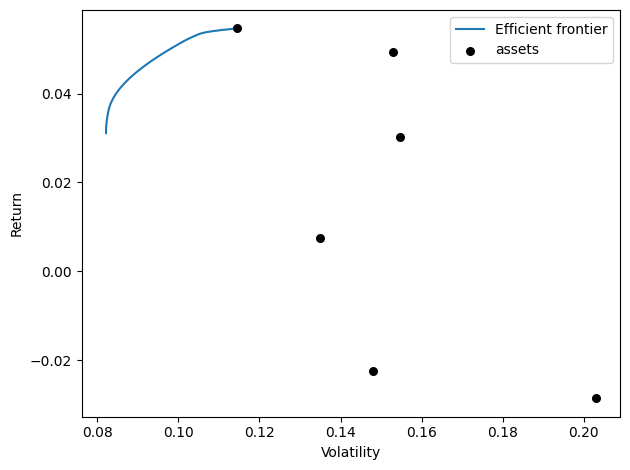

 VERY HIGH risk — targeting highest return: 5.46%

 Optimized Sector Weights:
Communication Services: 0.00%
Consumer Cyclical: 0.00%
Energy: 0.09%
Financial Services: 99.91%
Healthcare: 0.00%
Technology: 0.00%
Expected annual return: 5.5%
Annual volatility: 11.4%
Sharpe Ratio: 0.48


OrderedDict([('Communication Services', 0.0),
             ('Consumer Cyclical', 0.0),
             ('Energy', 0.00094),
             ('Financial Services', 0.99911),
             ('Healthcare', 0.0),
             ('Technology', 0.0)])

In [14]:
optimize_sector_portfolio2( risk_level="very high")

In [6]:
optimize_sector_portfolio2( risk_level="high")

 HIGH risk — targeting high return: 3.38%

 Optimized Sector Weights:
Communication Services: 12.60%
Consumer Cyclical: 3.21%
Energy: 19.98%
Financial Services: 34.10%
Healthcare: 30.11%
Technology: 0.00%
Expected annual return: 3.4%
Annual volatility: 8.2%
Sharpe Ratio: 0.41


OrderedDict([('Communication Services', 0.12603),
             ('Consumer Cyclical', 0.03207),
             ('Energy', 0.19981),
             ('Financial Services', 0.34097),
             ('Healthcare', 0.30111),
             ('Technology', 0.0)])

In [7]:
optimize_sector_portfolio2( risk_level="mid")

 MID risk — targeting medium return: 1.30%

 Optimized Sector Weights:
Communication Services: 11.88%
Consumer Cyclical: 6.68%
Energy: 19.44%
Financial Services: 31.30%
Healthcare: 30.71%
Technology: 0.00%
Expected annual return: 3.1%
Annual volatility: 8.2%
Sharpe Ratio: 0.38


OrderedDict([('Communication Services', 0.11876),
             ('Consumer Cyclical', 0.06684),
             ('Energy', 0.19436),
             ('Financial Services', 0.31298),
             ('Healthcare', 0.30707),
             ('Technology', 0.0)])

In [8]:
optimize_sector_portfolio2( risk_level="low")

 LOW risk — targeting conservative return: -0.77%

 Optimized Sector Weights:
Communication Services: 11.88%
Consumer Cyclical: 6.68%
Energy: 19.44%
Financial Services: 31.30%
Healthcare: 30.71%
Technology: 0.00%
Expected annual return: 3.1%
Annual volatility: 8.2%
Sharpe Ratio: 0.38


OrderedDict([('Communication Services', 0.11876),
             ('Consumer Cyclical', 0.06684),
             ('Energy', 0.19436),
             ('Financial Services', 0.31298),
             ('Healthcare', 0.30707),
             ('Technology', 0.0)])

In [9]:
optimize_sector_portfolio2( risk_level="very low")

 VERY LOW risk — targeting minimum return: -2.85%

 Optimized Sector Weights:
Communication Services: 11.88%
Consumer Cyclical: 6.68%
Energy: 19.44%
Financial Services: 31.30%
Healthcare: 30.71%
Technology: 0.00%
Expected annual return: 3.1%
Annual volatility: 8.2%
Sharpe Ratio: 0.38


OrderedDict([('Communication Services', 0.11876),
             ('Consumer Cyclical', 0.06684),
             ('Energy', 0.19436),
             ('Financial Services', 0.31298),
             ('Healthcare', 0.30707),
             ('Technology', 0.0)])